# Interpreting Black-Box Machine Learning Algorithms with LIME
TODO

In [9]:
%matplotlib inline

import lime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load Data and Yield Pandas DataFrame
Load the auction data from CSV file and take a glimpse. In practice, the data need not be in CSV format and could be collected via Spark and then transformed to a Pandas DataFrame directly from a Spark DataFrame, etc.

In [10]:
auction_eval = pd.read_csv('../data/auction_data.csv')

auction_eval.info()
auction_eval.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6220 entries, 0 to 6219
Data columns (total 11 columns):
auction_id         6220 non-null int64
avg_start_bid      6220 non-null float64
product_types      6220 non-null float64
auction_mech       6220 non-null object
lots               6220 non-null int64
BPL                6220 non-null float64
RoR                6220 non-null float64
auction_revenue    6220 non-null float64
auction_value      6220 non-null float64
country            6220 non-null object
avg_reserve        6220 non-null float64
dtypes: float64(7), int64(2), object(2)
memory usage: 534.6+ KB


,auction_id,avg_start_bid,product_types,auction_mech,lots,BPL,RoR,auction_revenue,auction_value,country,avg_reserve
0,1324,0.000000,0.822222,EnglishForward,45,11.066667,0.984284,35260.193359,994062.735352,TR,22090.283008
1,1325,0.000000,0.634615,EnglishForward,52,11.000000,0.000000,0.000000,975453.023438,TR,18758.711989
2,1326,0.161214,1.000000,EnglishForward,4,7.000000,0.774436,27755.481689,38372.630859,CZ,9593.157715
3,1327,0.000000,0.857143,EnglishForward,28,17.464286,0.933634,373000.000000,453479.647461,EU,16195.701695
4,1328,0.000000,0.820513,EnglishForward,39,11.487179,0.957757,328000.000000,340600.000000,EU,8733.333333


### Data Description
- **auction_id** - unique identifier for a single multi-lot online auction event;
- **auction revenue** - revenue realised from all lots sold in a multi-lot online auction event;
- **auction value** - the estimated value of all lots in a multi-lot online auction event (sum of reserve prices);
- **RoR** - the average Return-on-Reserve for successfully sold lots in the multi-lot online auction event, computed as realised price divided by reserve price;
- **lots** - the number of lots offered in the multi-lot online auction event;
- **product_types** - the number of different product types offered in the multi-lot online auction event;
- **avg_reserve** - the average reserve price over all lots in the multi-lot online auction event
- **avg_start_bid** - the average starting-bid (expressed as a fraction of the reserve bid), over all lots in the multi-lot online auction event
- **BPL** - the average number of bidders per-lot;
- **auction_mech** - the auction mechanim used for the auction event (one of English Forward, Sealed Bid or Fixed Price); and,
- **country** - the local market running the auction.

### Initial Variable Selection
We choose the following variables to use for trying to understand and predict RoR:
- **lots** - with the aim for controlling for the presence of available alternatives;
- **avg_reserve** - to control for lot value - e.g. lower value lots may see more bidders willing to go above the reserve and vice-versa;
- **avg_start_bid** - to control for the presence of a public price signal (we may need to derive this);
- **BPL** - we know from basic auction theory, that the more bidders there are, then the better the expected prices will be;
- **auction_mech** - whether the lots were traded via English Forward (EF) or Sealed Bid (SB) auctions; and,
- **country** - to control for differences between local markets.

In [54]:
RoR = ['RoR']
model_vars = ['lots', 'product_types', 'avg_reserve', 'avg_start_bid', 'BPL', 'auction_mech', 'country']

### Outlier Removal and other Dataset Filtering
Some outliers have obviously still found their way into the data. So, we will limit our modelling dataset by filtering-out values that don't feel correct based on our knowledge of the data (and the issues embedded within it). As such, we will filter-out the top percentile of RoR values as we know there is ambiguity surrounding reserve prices. Likewise, we have spotted auction events with average reserve prices in the millions of Euros, so we will filter-out the top percentile of mean reserve price observations, as well.

We will also exclude Fixed Price (FP) auction events from the dataset as the RoR for these auction events is fixed at 1 and all auction events where nothing was sold and nothing can be said about price and RoR (i.e. where auction revenue = 0).

In [55]:
pctile_thold = 0.99

model_data = (
    auction_eval.copy()
    .loc[(auction_eval['auction_revenue'] > 0)
         & (auction_eval['auction_mech'] != 'FixedPrice')
         & (auction_eval['RoR'] < auction_eval['RoR'].quantile(pctile_thold))
         & (auction_eval['avg_reserve'] < auction_eval['avg_reserve'].quantile(pctile_thold)),
         :]
    .assign(country = auction_eval['country'].apply(lambda x: 'country_' + x),
            auction_mech = auction_eval['auction_mech'].apply(lambda x: 'auction_mech_' + x))
    [RoR + model_vars])

desc_vars = [
    'auction_id']

model_data.describe()

,RoR,lots,product_types,avg_reserve,avg_start_bid,BPL
count,4175.000000,4175.000000,4175.000000,4175.000000,4175.000000,4175.000000
mean,0.989743,48.491018,0.751323,11099.072681,0.205143,8.251535
std,0.140135,39.081027,0.183748,4910.386793,0.390067,4.722761
min,0.052569,1.000000,0.003030,400.000000,0.000000,1.000000
25%,0.921498,17.000000,0.666667,7378.053377,0.000000,3.833333
50%,1.000367,40.000000,0.780000,10218.566667,0.000000,8.700000
75%,1.041915,74.000000,0.868173,13731.054182,0.000000,11.673864
max,1.617087,516.000000,1.000000,30198.234375,1.000000,36.000000


## Modelling XXX
TODO

### Data Preparation Pipeline
We need to setup a data preparation pipeline for handling the systematic selection of features from the input DataFrame (and their mapping to a NumPy ndarray), feature scaling and handling (one-hot encoding) categorical data.

In [50]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from custom_transformers import DataFrameAdapter, CategoricalFeatureEncoder

numeric_cols = (
    model_data[model_vars]
    .select_dtypes(exclude=['object'])
    .columns)

numeric_pipeline = Pipeline([
    ('var_selector', DataFrameAdapter(numeric_cols)),
    ('scaler', StandardScaler())
])

categorical_cols = (
    model_data[model_vars]
    .select_dtypes(include=['object'])
    .columns)

categorical_pipeline = Pipeline([
    ('var_selector', DataFrameAdapter(categorical_cols)),
    ('categorical_encoder', CategoricalFeatureEncoder())
])

data_prep_pipeline = FeatureUnion([
    ('numeric_pipeline', numeric_pipeline),
    ('categorical_pipeline', categorical_pipeline)
])

y = (model_data
     ['RoR']
     .values
     .reshape(-1, ))

X = (data_prep_pipeline
     .fit_transform(model_data[model_vars]))

### Partition Data into Test and Train Sets

In [51]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

print('{} samples in training dataset and {} samples in test dataset'
      .format(X_train.shape[0], X_test.shape[0]))

3340 samples in training dataset and 835 samples in test dataset


### Define Experimental Setup
We will use RMSE as a test metric and 5-fold cross validation to get a basic estimate of the model's performance out-of-sample.

In [52]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

def rmse(model_fit, features, labels):
    predictions = model_fit.predict(features)
    rmse = np.sqrt(mean_squared_error(labels, predictions))
    print('In-sample RMSE = {}'.format(rmse))
    return None

def cv_results(model_fit, features, labels):
    scores = cross_val_score(model_fit, features, labels, scoring='neg_mean_squared_error', cv=5)
    cv_mean_rmse = np.sqrt(-scores).mean()
    cv_std_rmse = np.sqrt(-scores).std()
    print('Cross-Val RMSE = {} +/- {}'.format(cv_mean_rmse, cv_std_rmse))
    return None

### Estimate XX Regression Model
As a control (or reference point) to our Bayesian inference models we will also estimate a linear regression using stochastic gradient descenet methods (as these are more stable than OLS matrix inversions).

In [53]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(X_train, y_train)

rmse(forest_reg, X_train, y_train)
cv_results(forest_reg, X_train, y_train)

In-sample RMSE = 0.044534549204925784
Cross-Val RMSE = 0.10808254561586661 +/- 0.00833171130201439


We proceed to use grid search to find the best set of hyper-parameters.

In [65]:
from sklearn.model_selection import GridSearchCV

forest_reg_param_grid = [{
    'bootstrap': [True, False], 
    'n_estimators': [5, 10, 20, 30, 50], 
    'max_features': [2, 3, 4, 5, 6, 7],
    'random_state' : [42]
}]

forest_reg_grid = GridSearchCV(forest_reg, forest_reg_param_grid, cv=5, scoring='neg_mean_squared_error')
forest_reg_grid.fit(X_train, y_train)

print('best parameters on grid: {}'.format(forest_reg_grid.best_params_))
print('\nFULL RESULTS:')
forest_reg_grid_res = forest_reg_grid.cv_results_
for mean_score, params in zip(forest_reg_grid_res['mean_test_score'], forest_reg_grid_res['params']):
    print(np.sqrt(-mean_score), params)
    
forest_reg_opt = forest_reg_grid.best_estimator_    

best parameters on grid: {'bootstrap': True, 'max_features': 4, 'n_estimators': 50, 'random_state': 42}

FULL RESULTS:
0.11281053769419164 {'bootstrap': True, 'max_features': 2, 'n_estimators': 5, 'random_state': 42}
0.10875253223503209 {'bootstrap': True, 'max_features': 2, 'n_estimators': 10, 'random_state': 42}
0.10611284762006593 {'bootstrap': True, 'max_features': 2, 'n_estimators': 20, 'random_state': 42}
0.10504525807217627 {'bootstrap': True, 'max_features': 2, 'n_estimators': 30, 'random_state': 42}
0.10453457299758263 {'bootstrap': True, 'max_features': 2, 'n_estimators': 50, 'random_state': 42}
0.11305090253951108 {'bootstrap': True, 'max_features': 3, 'n_estimators': 5, 'random_state': 42}
0.10885223845761703 {'bootstrap': True, 'max_features': 3, 'n_estimators': 10, 'random_state': 42}
0.10586383082999014 {'bootstrap': True, 'max_features': 3, 'n_estimators': 20, 'random_state': 42}
0.1046482737010976 {'bootstrap': True, 'max_features': 3, 'n_estimators': 30, 'random_state

We now use the best-fit model to score the test dataset.

In-sample RMSE = 0.10231963542660905


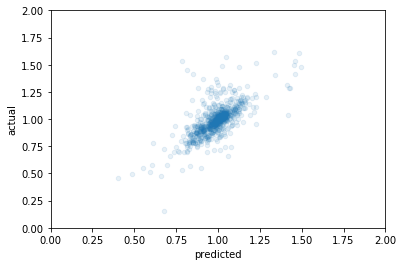

In [66]:
predicted = forest_reg_opt .predict(X_test)
error = predicted - y_test
abs_error = np.absolute(error)

model_performance = pd.DataFrame(
    np.concatenate([predicted.reshape((-1, 1)), y_test.reshape((-1, 1)), 
                    error.reshape((-1, 1)), abs_error.reshape((-1, 1))], axis=1), 
    columns=['predicted', 'actual', 'error', 'abs_error']
)

print('In-sample RMSE = {}'.format(np.sqrt(np.mean(error ** 2))))

plt = model_performance.plot(kind='scatter', x='predicted', y='actual', alpha=0.1, xlim=[0, 2], ylim=[0, 2])

## Model Interpretation using LIME
TODO

In [31]:
# TODO